In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import glob

from datetime import datetime, date

## To-do list
- Get clear on accuracy formula and calculations
- Standard deviations
- Optimization
- Repeat using a (non-deep learning) classifier of your choice.
- Discussions

In [2]:
def computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size):
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    n_cells = (RESIZE_DIM // cell_size[0], RESIZE_DIM // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(image)
    hog_feats = hog_feats.reshape(n_cells[1]-block_size[1]+1,
                                  n_cells[0]-block_size[0]+1,
                                  block_size[0], block_size[1], nbins)
    hog_feats = hog_feats.transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,
    #for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count

    gradients = gradients.reshape((1, -1))
    return gradients

def resizeImage(image, dimension):
    imy, imx = image.shape[0:2]
    M = np.float32([[dimension/imx, 0, 0], [0, dimension/imy, 0]])
    image = cv2.warpAffine(image, M, (RESIZE_DIM, RESIZE_DIM))
    return image

In [3]:
""" With limited image count"""

#display
startGlobal = datetime.time(datetime.now())

# #testing
categoriesTest  = [
#      "car",
#      "background",
#      "pickup_truck",
#     "articulated_truck",
#     "bus",
     "work_van",
     "pedestrian",
    "single_unit_truck",
    "bicycle",
    "motorcycle",
    "non-motorized_vehicle"]
#endTesting
#^We notice that runtime is minimized of operations occur on the largest categories first
numCategories = len(categoriesTest)

"""
################################################
 Setting a limit of 2000 images to speed up
 computations and balance proportion of images
################################################
"""

#TEMP
sumIm = 0
for i in range(numCategories):
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])
#     numImages = len(glob.glob(path))
    if len(glob.glob(path)) > 2000: numImages = 2000
    sumIm = sumIm + numImages
#End TEMP

RESIZE_DIM = 64
# totalNumIm = 519164 #MAY GIVE MEMORY ERROR
#testing
totalNumIm = sumIm
#End testing
globalImCtr = 0

#HoG variables
#Raw variables
cell_size = (4,4)
block_size = (4, 4)

#variables for computation
winSize = (RESIZE_DIM // cell_size[1] * cell_size[1], RESIZE_DIM // cell_size[0] * cell_size[0] )
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
blockStride = (cell_size[1], cell_size[0])
cellSize = (cell_size[1], cell_size[0])
nbins = 8
#End HoG variables

totalNumFeatures = RESIZE_DIM // cell_size[1] * RESIZE_DIM // cell_size[0] * nbins

#array initialization
labelsArray = np.zeros(totalNumIm, dtype=np.int)
featuresArray = np.zeros((totalNumIm, totalNumFeatures))
indexArray = np.arange(totalNumIm, dtype=np.int)
np.random.shuffle(indexArray)         

# Read input images category by category
for i in range(numCategories):
    start = datetime.time(datetime.now())

    #specifying path to images
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])

    #Variable initializations
    categoryImgCnt = 0
    nextPctg = 5
    numImages = len(glob.glob(path))
    if numImages > 2000: numImages = 2000

    #display
    print("Loading Images for category:    >>>" + categoriesTest[i] + "<<<    " + str(numImages) + " images of " 
          + str(len(glob.glob(path))) + " total images")
    print("    Percentage Completed: 0%-", end='')

    # for each image in the category folder
#     for file in glob.glob(path):
    imgCounter = 0
    for file in glob.glob(path):
        if imgCounter < numImages:
            imgCounter += 1
            #read, convert color, get features, stor info
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #resizing IF NECESSARY
            #TRY to do HoG without resizing image. to be discussed
            image = resizeImage(image, RESIZE_DIM)
            #end resize

            #Computing features
            #HoG features
            gradients = computeHoG(image, winSize, blockSize, blockStride, cellSize,
                                   nbins, RESIZE_DIM, cell_size, block_size)

            randomIndex = indexArray[globalImCtr]
            featuresArray[randomIndex] = gradients
            labelsArray[randomIndex] = i
            #End Feature computation

            #variable update
            globalImCtr = globalImCtr + 1
            categoryImgCnt = categoryImgCnt + 1

            #display
            if (int(categoryImgCnt*100/numImages)) == nextPctg:
                print(str(nextPctg) + "%", end='')
                if nextPctg != 100 : print("-", end='')
                nextPctg = nextPctg + 5
        else:
            # dont load more than 2000 imgs
            break
    #display        
    print("")
#     print("loaded " + str(imgCounter) + " images")
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))

#display
endGlobal = datetime.time(datetime.now())
duration = datetime.combine(date.today(), endGlobal) - datetime.combine(date.today(), startGlobal)
print(">Total duration: " + str(duration))
print(labelsArray[:100])

Loading Images for category:    >>>work_van<<<    2000 images of 9679 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:03.558970
Loading Images for category:    >>>pedestrian<<<    2000 images of 6262 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:02.464595
Loading Images for category:    >>>single_unit_truck<<<    2000 images of 5120 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:03.717878
Loading Images for category:    >>>bicycle<<<    2000 images of 2284 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:02.371648
Loading Images for category:    >>>motorcycle<<<    1982 images of 1982 total images
    Percentage Comple

In [4]:
print("Size of featuresArray: ", featuresArray.shape)
print("Size of labelsArray: ", labelsArray.shape)

Size of featuresArray:  (12000, 2048)
Size of labelsArray:  (12000,)


Updates:
  Note: 
    Precision: Of the predictions made for class C, what fraction was correct?
    Recall: ”Of the samples for class C, how many were correctly predicted?

  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in same folder as this .ipynb file.

Would you like to build or load the classifiers? no
  'no' is not a valid input -> type 'help' for help

Would you like to build or load the classifiers? HELP
  Available commands: Build, Load, Help, Exit

Would you like to build or load the classifiers? build
  Would you like to save the classifiers? yeah
    Invalid input -> 'yes' or 'no'

  Would you like to save the classifiers? yes
    Classifiers will be saved


  Creating classifier 0
    Duration: 0:02:37.011464
  Saving classifier 0 as >>classifier_0.sav<<
  Getting predictions for classifier 0
    Duration: 0:00:16.979315
  For subset 0:
    For category work_van: TP=186, FP=46, FN=44, TN=924
      Accuracy = 92.50%      Precision = 80.17%    

    Duration: 0:02:44.355263
  Saving classifier 8 as >>classifier_8.sav<<
  Getting predictions for classifier 8
    Duration: 0:00:17.815346
  For subset 8:
    For category work_van: TP=176, FP=63, FN=58, TN=903
      Accuracy = 89.92%      Precision = 73.64%      Recall = 75.21%
    For category pedestrian: TP=148, FP=61, FN=56, TN=935
      Accuracy = 90.25%      Precision = 70.81%      Recall = 72.55%
    For category single_unit_truck: TP=147, FP=51, FN=61, TN=941
      Accuracy = 90.67%      Precision = 74.24%      Recall = 70.67%
    For category bicycle: TP=125, FP=49, FN=58, TN=968
      Accuracy = 91.08%      Precision = 71.84%      Recall = 68.31%
    For category motorcycle: TP=130, FP=68, FN=73, TN=929
      Accuracy = 88.25%      Precision = 65.66%      Recall = 64.04%
    For category non-motorized_vehicle: TP=108, FP=74, FN=60, TN=958
      Accuracy = 88.83%      Precision = 59.34%      Recall = 64.29%
  Average accuracy of subset 8 = 89.83%

  Creating classifier 9
 

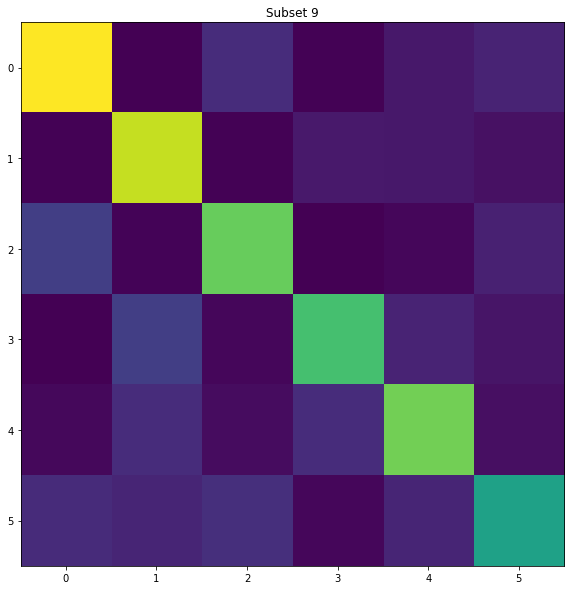

Legend:
  0: work_van
  1: pedestrian
  2: single_unit_truck
  3: bicycle
  4: motorcycle
  5: non-motorized_vehicle

Overall average accuracy is 90.34%

Done, total duration: 0:29:20.985269


In [5]:
print("Updates:")

print("  Note: ")
print("    This is the deep learning implementation of the classifier.")
print("    In this implementation we use an SVM classifier")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?\n")
print("  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in same" 
     + " folder as this .ipynb file.\n")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
accuracyArray = []

while(1):
    inputStr = input("Would you like to build or load the SVM classifiers? ")
    
    inputStr = inputStr.lower()
    
    if inputStr == 'exit':
        print("  Program exiting\n")
        break
    
    elif inputStr == 'help':
        print("  Available commands: Build, Load, Help, Exit\n")
    
    elif inputStr == 'build' or inputStr == 'load':
        # proceed and build or load classifiers
        realStart = datetime.time(datetime.now())
       
        for subsetIndex in range(numSubset):
            data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
            labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
            data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                         featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
            labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                           labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    
        #     print("data_train shape:", data_train.shape)
        #     print("d")
    
            ################################################
            """Building the classifiers"""
            if inputStr == 'build':
                while(subsetIndex==0):
                    inputSave = input("  Would you like to save the classifiers? ")
                    inputSave = inputSave.lower()
                    
                    if inputSave == 'no':
                        save = 0
                        print("    Classifiers will not be saved\n")
                        break
                    
                    elif inputSave == 'yes':
                        save = 1
                        print("    Classifiers will be saved\n")
                        break
                    
                    else:
                        print("    Invalid input -> 'yes' or 'no'\n")
                    
                print("\n  Creating classifier " + str(subsetIndex))
                start = datetime.time(datetime.now())
                clf = svm.SVC(C = 100.) # default kernel='rfb'
                clf.fit(data_train, labels_train)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
                
                """Saving the classifiers"""
                if save == 1:
                    filename = ('classifier_%i.sav' % subsetIndex)
                    print("  Saving classifier " + str(subsetIndex) + " as >>" + filename + "<<")
                    joblib.dump(clf, filename)

            ################################################
            
            ################################################
            
            elif inputStr == 'load':
                """Loading the classifiers"""
                filename = ('classifier_%i.sav' % subsetIndex)
                print("\n  Loading classifier >>" + filename + "<<")
                clf = joblib.load(filename)
            ################################################
    
            print("  Getting predictions for classifier " + str(subsetIndex))
            start = datetime.time(datetime.now())
            prediction = clf.predict(data_test)
            end = datetime.time(datetime.now())
            print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
            # Precision
            # for each class, get the precision (then average of all classes for all subset?)
            print("  For subset " + str(subsetIndex) + ":")
    
        #     print("prediction shape:", prediction.shape)
    
            totalTP = 0
            totalTN = 0
    
            for category in range(numCategories):
                TP = 0
                FP = 0
                FN = 0
                TN = 0
                for n in range(len(prediction)):
                    if prediction[n] == category:
                        if labels_test[n] == category:
                            # got a true positive
                            TP += 1
                            totalTP += 1
                        else:
                            # got a false positive
                            FP += 1
                        continue
    
                    if prediction[n] != category:
                        if labels_test[n] == category:
                            # got a false negative
                            FN += 1
                        else:
                            # got a true negative
                            TN += 1
                            totalTN += 1
                        continue
    
                    else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                                + ", Correct: " + str(labels_test[n]))
    
                print("    For category " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
                      + ", FN=" + str(FN) + ", TN=" + str(TN))
    
                accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
                precision = TP/(TP+FP)*100
                recall = TP/(TP+FN)*100
    
                print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
                print("      Precision = %.2f" % precision + "%", end='')
                print("      Recall = %.2f" % recall + "%")
    
            subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
            print("  Average accuracy of subset %i = %.2f" % (subsetIndex, subAcc) + "%")
            accuracyArray.append(subAcc)
    
            # Confusion Matrix for last subset only
            ################################################
            # Do we only need one?
            ################################################
            if subsetIndex == numSubset-1:
                print("  Creating confusion matrix " + str(subsetIndex))
                start = datetime.time(datetime.now())
                confMat = confusion_matrix(labels_test, prediction)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
                plt.figure(figsize=(10,10))
                plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
                plt.show()
    
                # display categories and their label
                print("Legend:")
                for cat in range(len(categoriesTest)):
                    print("  " + str(cat) + ": " + str(categoriesTest[cat]))
    
        # calculate the overall average accuracy
        avgAccuracy = 0
        avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
        print("\nOverall average accuracy is %.2f" % (avgAccuracy) + "%")
    
        realEnd = datetime.time(datetime.now())
        print("\nDone, total duration: " + str(datetime.combine(date.today(), realEnd) 
                                               - datetime.combine(date.today(), realStart)))
        break
    
    else:
        # not a valid input
        print("  '" + inputStr + "' is not a valid input -> type 'help' for help\n")

In [ ]:
print("Updates:")

print("  Note: ")
print("    This is the non-deep learning implementation of the classifier.")
print("    In this implementation we use a kneighbor classifier")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?\n")
print("  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in same" 
     + " folder as this .ipynb file.\n")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
accuracyArray = []

while(1):
    inputStr = input("Would you like to build or load the kNeighbors classifiers? ")
    
    inputStr = inputStr.lower()
    
    if inputStr == 'exit':
        print("  Program exiting\n")
        break
    
    elif inputStr == 'help':
        print("  Available commands: Build, Load, Help, Exit\n")
    
    elif inputStr == 'build' or inputStr == 'load':
        # proceed and build or load classifiers
        realStart = datetime.time(datetime.now())
       
        for subsetIndex in range(numSubset):
            data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
            labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
            data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                         featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
            labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                           labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    
        #     print("data_train shape:", data_train.shape)
        #     print("d")
    
            ################################################
            """Building the classifiers"""
            if inputStr == 'build':
                while(subsetIndex==0):
                    inputSave = input("  Would you like to save the classifiers? ")
                    inputSave = inputSave.lower()
                    
                    if inputSave == 'no':
                        save = 0
                        print("    Classifiers will not be saved\n")
                        break
                    
                    elif inputSave == 'yes':
                        save = 1
                        print("    Classifiers will be saved\n")
                        break
                    
                    else:
                        print("    Invalid input -> 'yes' or 'no'\n")
                    
                print("\n  Creating classifier " + str(subsetIndex))
                start = datetime.time(datetime.now())
                clf_kneighbors = neighbors.KNeighborsClassifier(3)
                clf_kneighbors.fit(data_train, labels_train)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
                
                """Saving the classifiers"""
                if save == 1:
                    filename = ('kNeighborsclassifier_%i.sav' % subsetIndex)
                    print("  Saving classifier " + str(subsetIndex) + " as >>" + filename + "<<")
                    joblib.dump(clf_kneighbors, filename)

            ################################################
            
            ################################################
            
            elif inputStr == 'load':
                """Loading the classifiers"""
                filename = ('kNeighborsclassifier_%i.sav' % subsetIndex)
                print("\n  Loading classifier >>" + filename + "<<")
                clf_kneighbors = joblib.load(filename)
            ################################################
    
            print("  Getting predictions for classifier " + str(subsetIndex))
            start = datetime.time(datetime.now())
            prediction = clf_kneighbors.predict(data_test)
            end = datetime.time(datetime.now())
            print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
            # Precision
            # for each class, get the precision (then average of all classes for all subset?)
            print("  For subset " + str(subsetIndex) + ":")
    
        #     print("prediction shape:", prediction.shape)
    
            totalTP = 0
            totalTN = 0
    
            for category in range(numCategories):
                TP = 0
                FP = 0
                FN = 0
                TN = 0
                for n in range(len(prediction)):
                    if prediction[n] == category:
                        if labels_test[n] == category:
                            # got a true positive
                            TP += 1
                            totalTP += 1
                        else:
                            # got a false positive
                            FP += 1
                        continue
    
                    if prediction[n] != category:
                        if labels_test[n] == category:
                            # got a false negative
                            FN += 1
                        else:
                            # got a true negative
                            TN += 1
                            totalTN += 1
                        continue
    
                    else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                                + ", Correct: " + str(labels_test[n]))
    
                print("    For category " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
                      + ", FN=" + str(FN) + ", TN=" + str(TN))
    
                accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
                precision = TP/(TP+FP)*100
                recall = TP/(TP+FN)*100
    
                print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
                print("      Precision = %.2f" % precision + "%", end='')
                print("      Recall = %.2f" % recall + "%")
    
            subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
            print("  Average accuracy of subset %i = %.2f" % (subsetIndex, subAcc) + "%")
            accuracyArray.append(subAcc)
    
            # Confusion Matrix for last subset only
            ################################################
            # Do we only need one?
            ################################################
            if subsetIndex == numSubset-1:
                print("  Creating confusion matrix " + str(subsetIndex))
                start = datetime.time(datetime.now())
                confMat = confusion_matrix(labels_test, prediction)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
                plt.figure(figsize=(10,10))
                plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
                plt.show()
    
                # display categories and their label
                print("Legend:")
                for cat in range(len(categoriesTest)):
                    print("  " + str(cat) + ": " + str(categoriesTest[cat]))
    
        # calculate the overall average accuracy
        avgAccuracy = 0
        avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
        print("\nOverall average accuracy is %.2f" % (avgAccuracy) + "%")
    
        realEnd = datetime.time(datetime.now())
        print("\nDone, total duration: " + str(datetime.combine(date.today(), realEnd) 
                                               - datetime.combine(date.today(), realStart)))
        break
    
    else:
        # not a valid input
        print("  '" + inputStr + "' is not a valid input -> type 'help' for help\n")
    
    